### Multi-omic Dataset: Latent representation using Autoencoders
- Load Data
- Normalize Data
- Define Autoencoder Model
- Train Autoencoder with normalized dataset
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [1]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_brca_mRNA_data = pd.read_csv('./BRCA_mRNA.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_CNA_data = pd.read_csv('./BRCA_CNA.txt', sep=',' ,index_col=0) # Dataset has Donor ID as first column
y_brca_data = pd.read_csv('./BRCA_Clinical.txt', sep=',', index_col=0, names=["Label"]) # Dataset has Donor ID on first column and Label on second column.

X_brca_mRNA_filtered = X_brca_mRNA_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=1)
X_brca_CNA_filtered = X_brca_CNA_data.drop(["TCGA-AR-A0U1-01"], axis=1)
y_brca_filtered = y_brca_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=0)


X_train_first_norm, X_train_second_norm, X_swapped_first_norm, X_swapped_second_norm, X_test_first_norm, X_test_second_norm, X_train_concat, X_swapped_concat, X_test_concat, y_train, y_test, y_train_oh, y_test_oh \
    = Models.prepare_datasets(X_brca_mRNA_filtered.T,X_brca_CNA_filtered.T, y_brca_filtered, test_size=0.2, swap_noise=0.15)


swapping: 20 rows.


In [22]:
## USEFUL TO CHECK SAMPLE DIFFERENCE
X_brca_CNA_filtered = X_brca_CNA_filtered[X_brca_CNA_filtered.columns.difference(X_brca_mRNA_data.columns)]
X_brca_mRNA_filtered = X_brca_mRNA_filtered[X_brca_mRNA_filtered.columns.difference(X_brca_CNA_data.columns)]

## CONCAT DATASETS
pd.concat([X_brca_mRNA_filtered.T, X_brca_CNA_filtered.T],axis=1)

,DonorID,Label
0,TCGA-3C-AAAU-01,0
1,TCGA-3C-AALI-01,0
2,TCGA-A1-A0SK-01,1
3,TCGA-A2-A04N-01,0
4,TCGA-A2-A04P-01,1
...,...,...
161,TCGA-PE-A5DD-01,0
162,TCGA-PE-A5DE-01,0
163,TCGA-UU-A93S-01,1
164,TCGA-Z7-A8R5-01,0


In [38]:
import importlib
importlib.reload(Models)

<module 'Models' from 'C:\\Desarrollo\\Data Science\\Jupyter Notebooks\\Stage\\oss-stage-2019\\Multiomic Dataset\\Models.py'>

Compression: 70.58666666666667

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00106: early stopping


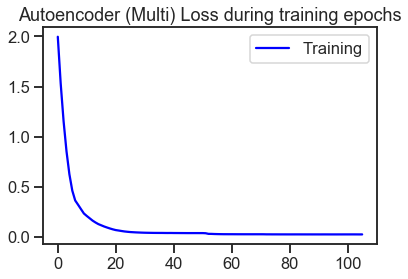

0.02524073989345477


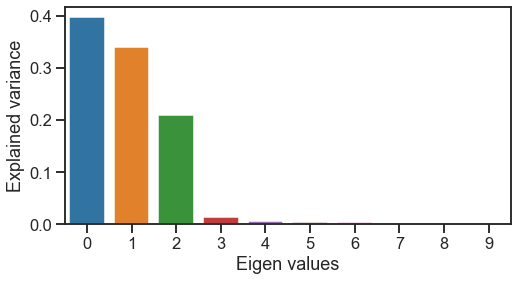

PCA on single-modal explained variance ratio: 0.9843593835830688


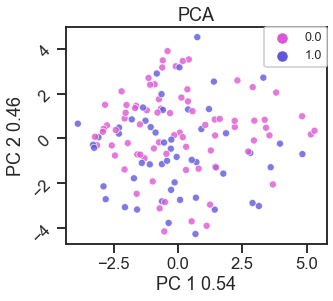

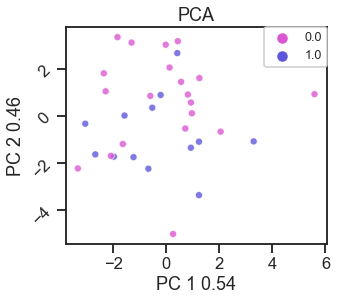

Results for AE: 

Best score for training data: 0.6153846153846153 

Best C: 0.08 



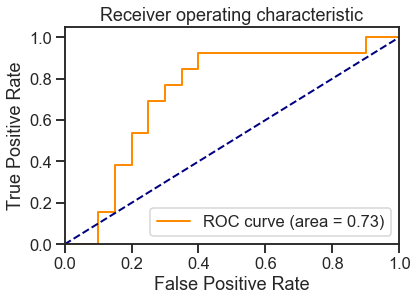

[[16  4]
 [ 8  5]]


              precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       0.56      0.38      0.45        13

    accuracy                           0.64        33
   macro avg       0.61      0.59      0.59        33
weighted avg       0.62      0.64      0.62        33

Training set score for Logistic Regression: 0.653846
Testing  set score for Logistic Regression: 0.636364
Best score for training data: 0.5923076923076923 

Best C: 0.1 

Best Gamma: scale 



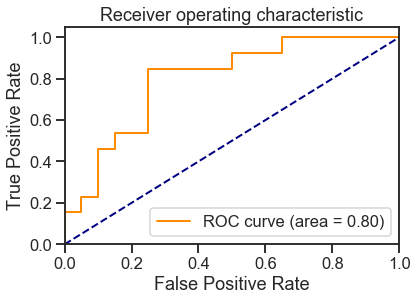

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33

Training set score for SVM: 0.592308
Testing  set score for SVM: 0.606061


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score for training data: 0.6153846153846153 

Best #estimators: 140 

Best max depth: None 



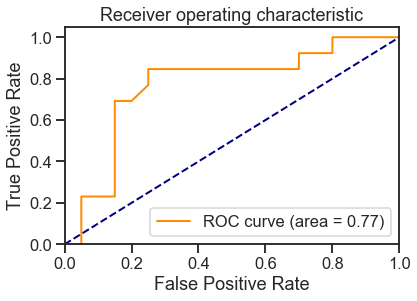

[[17  3]
 [ 4  9]]


              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.75      0.69      0.72        13

    accuracy                           0.79        33
   macro avg       0.78      0.77      0.77        33
weighted avg       0.79      0.79      0.79        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.787879
mutual information: 0.0014525087189200339
AE 2 clusters -  silhoutte score: 0.2623341977596283
AE 3 clusters -  silhoutte score: 0.26416224241256714
AE 4 clusters -  silhoutte score: 0.3059409558773041
AE 5 clusters -  silhoutte score: 0.29677948355674744
AE 6 clusters -  silhoutte score: 0.2971457540988922


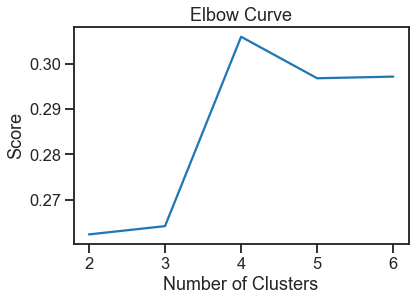

mutual information: 0.0024996240577667903
AE 2 clusters -  silhoutte score: 0.2722399830818176
AE 3 clusters -  silhoutte score: 0.24571622908115387
AE 4 clusters -  silhoutte score: 0.18298152089118958
AE 5 clusters -  silhoutte score: 0.22122177481651306
AE 6 clusters -  silhoutte score: 0.23451188206672668


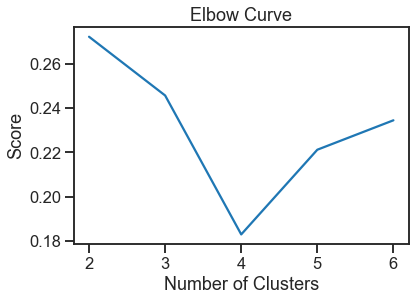

mutual information: 0.003380451761710477
AE 2 clusters -  silhoutte score: 0.2825413644313812
AE 3 clusters -  silhoutte score: 0.2392171323299408
AE 4 clusters -  silhoutte score: 0.2926831841468811
AE 5 clusters -  silhoutte score: 0.27590906620025635
AE 6 clusters -  silhoutte score: 0.2939784526824951


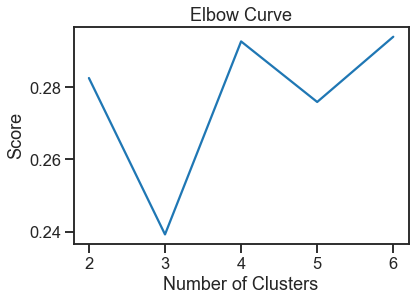

Compression: 70.58666666666667

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00089: early stopping


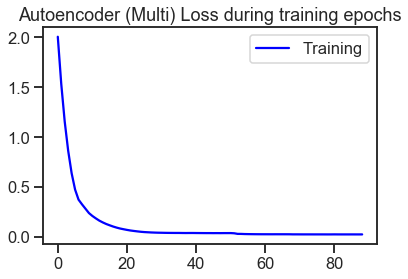

0.02589867043380554


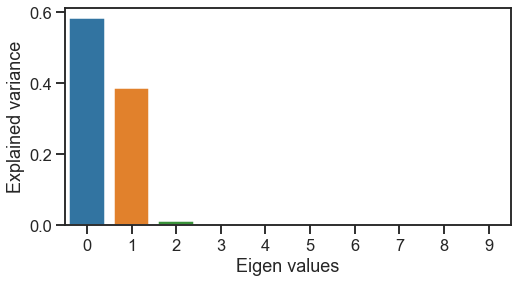

PCA on single-modal explained variance ratio: 0.9963973164558411


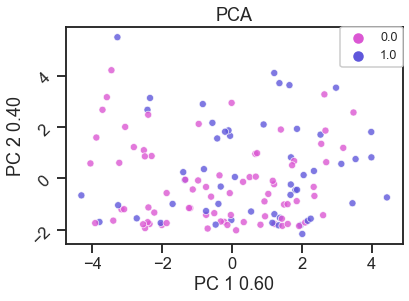

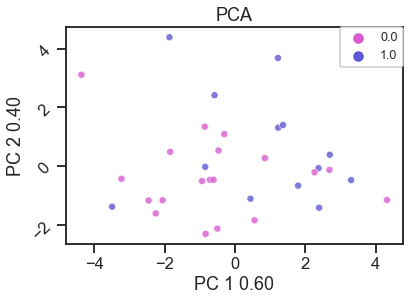

Results for AE: 

Best score for training data: 0.6384615384615385 

Best C: 0.08 



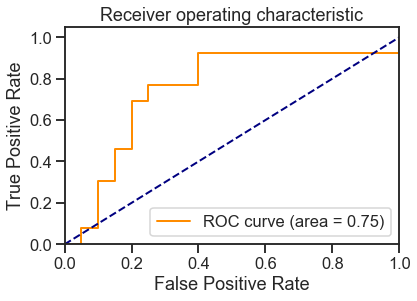

[[16  4]
 [ 6  7]]


              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.64      0.54      0.58        13

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33

Training set score for Logistic Regression: 0.638462
Testing  set score for Logistic Regression: 0.696970
Best score for training data: 0.6153846153846153 

Best C: 1.0 

Best Gamma: 0.1 



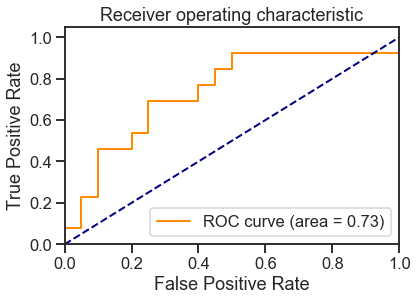

[[18  2]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       0.67      0.31      0.42        13

    accuracy                           0.67        33
   macro avg       0.67      0.60      0.59        33
weighted avg       0.67      0.67      0.63        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.666667
Best score for training data: 0.5538461538461539 

Best #estimators: 140 

Best max depth: None 



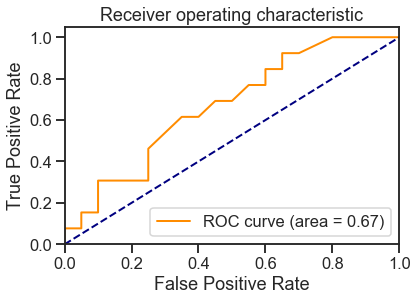

[[16  4]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.64      0.80      0.71        20
           1       0.50      0.31      0.38        13

    accuracy                           0.61        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.58      0.61      0.58        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061
mutual information: 0.005941705616397975
AE 2 clusters -  silhoutte score: 0.3675196170806885
AE 3 clusters -  silhoutte score: 0.3844743072986603
AE 4 clusters -  silhoutte score: 0.3724384605884552
AE 5 clusters -  silhoutte score: 0.36352649331092834
AE 6 clusters -  silhoutte score: 0.378726601600647


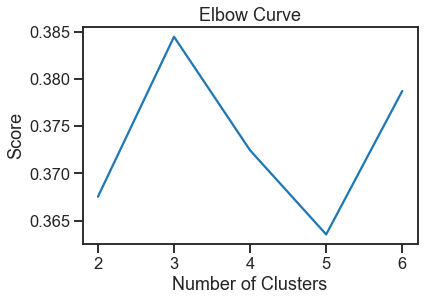

mutual information: 0.02488811780349315
AE 2 clusters -  silhoutte score: 0.38259124755859375
AE 3 clusters -  silhoutte score: 0.3230326175689697
AE 4 clusters -  silhoutte score: 0.2889379858970642
AE 5 clusters -  silhoutte score: 0.30039480328559875
AE 6 clusters -  silhoutte score: 0.32821595668792725


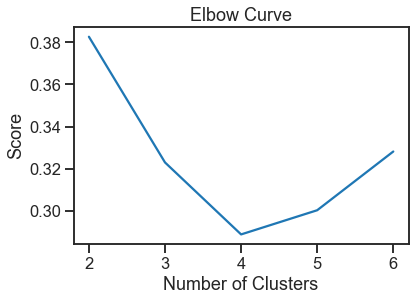

mutual information: 0.04081887135568909
AE 2 clusters -  silhoutte score: 0.3627565801143646
AE 3 clusters -  silhoutte score: 0.3564564883708954
AE 4 clusters -  silhoutte score: 0.3803974390029907
AE 5 clusters -  silhoutte score: 0.34685641527175903
AE 6 clusters -  silhoutte score: 0.34125572443008423


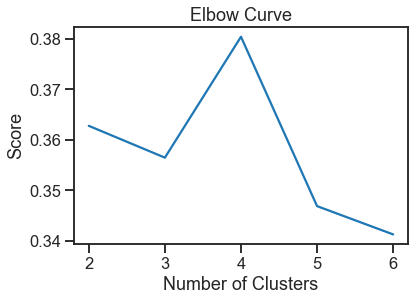

Compression: 70.58666666666667

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00110: early stopping


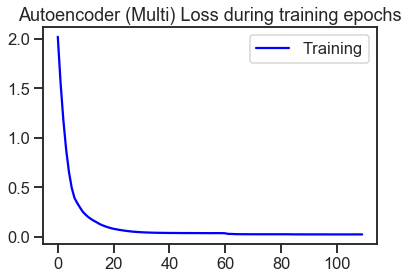

0.026536318774406726


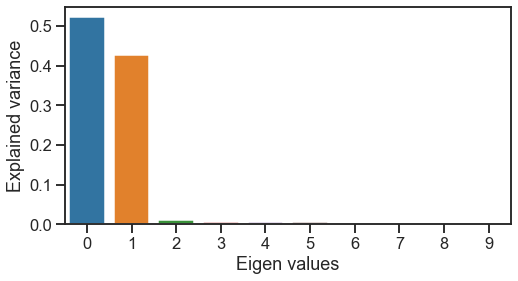

PCA on single-modal explained variance ratio: 0.9869855046272278


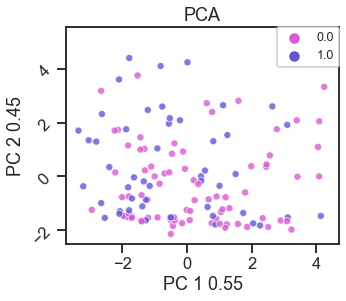

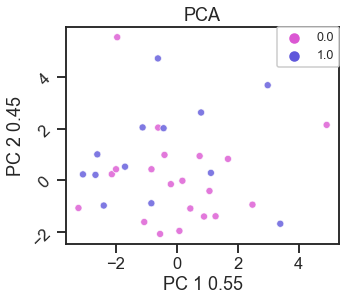

Results for AE: 

Best score for training data: 0.6384615384615385 

Best C: 0.08 



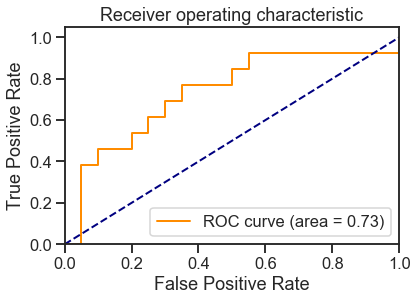

[[15  5]
 [ 6  7]]


              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.58      0.54      0.56        13

    accuracy                           0.67        33
   macro avg       0.65      0.64      0.65        33
weighted avg       0.66      0.67      0.66        33

Training set score for Logistic Regression: 0.646154
Testing  set score for Logistic Regression: 0.666667
Best score for training data: 0.6153846153846154 

Best C: 1.0 

Best Gamma: 0.1 



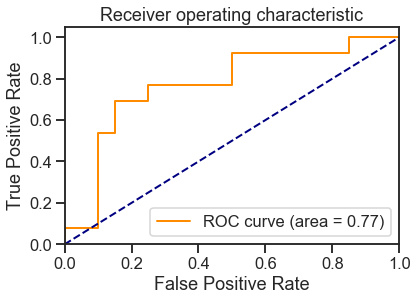

[[17  3]
 [ 6  7]]


              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.70      0.54      0.61        13

    accuracy                           0.73        33
   macro avg       0.72      0.69      0.70        33
weighted avg       0.72      0.73      0.72        33

Training set score for SVM: 0.692308
Testing  set score for SVM: 0.727273
Best score for training data: 0.6076923076923076 

Best #estimators: 100 

Best max depth: 12 



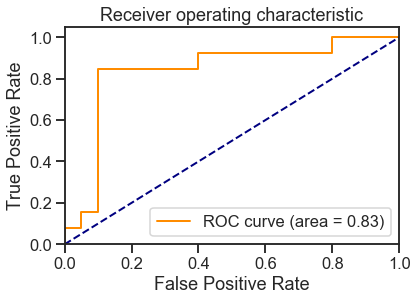

[[17  3]
 [ 2 11]]


              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.79      0.85      0.81        13

    accuracy                           0.85        33
   macro avg       0.84      0.85      0.84        33
weighted avg       0.85      0.85      0.85        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.848485
mutual information: 0.005131508098300968
AE 2 clusters -  silhoutte score: 0.3476490080356598
AE 3 clusters -  silhoutte score: 0.3588859438896179
AE 4 clusters -  silhoutte score: 0.37815892696380615
AE 5 clusters -  silhoutte score: 0.34196987748146057
AE 6 clusters -  silhoutte score: 0.3235108256340027


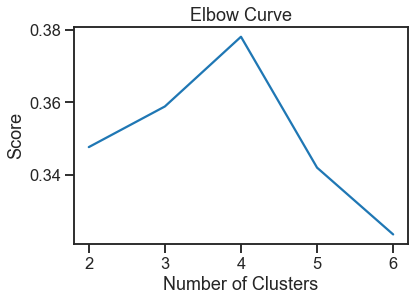

mutual information: 0.02508131975907922
AE 2 clusters -  silhoutte score: 0.31710198521614075
AE 3 clusters -  silhoutte score: 0.34555086493492126
AE 4 clusters -  silhoutte score: 0.2834639251232147
AE 5 clusters -  silhoutte score: 0.3448801338672638
AE 6 clusters -  silhoutte score: 0.31991273164749146


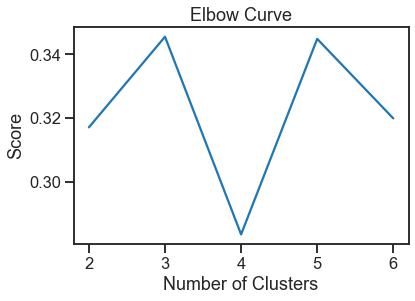

mutual information: 0.02513997645725408
AE 2 clusters -  silhoutte score: 0.3319322466850281
AE 3 clusters -  silhoutte score: 0.34173449873924255
AE 4 clusters -  silhoutte score: 0.33364173769950867
AE 5 clusters -  silhoutte score: 0.3194507956504822
AE 6 clusters -  silhoutte score: 0.32057487964630127


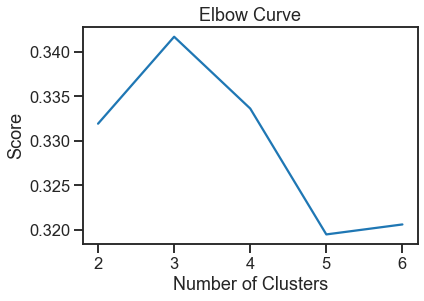

Compression: 70.58666666666667

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00109: early stopping


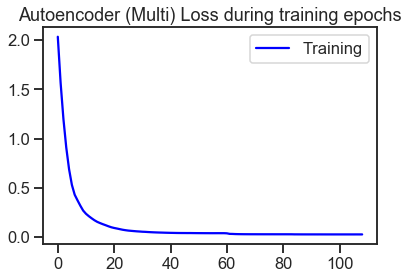

0.027551087278586166


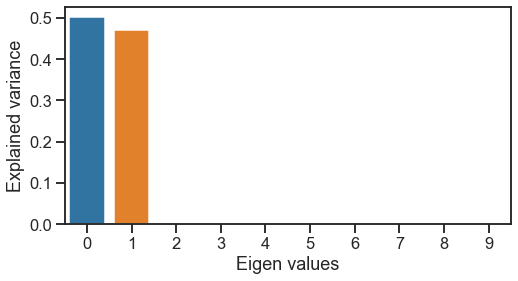

PCA on single-modal explained variance ratio: 0.9932985305786133


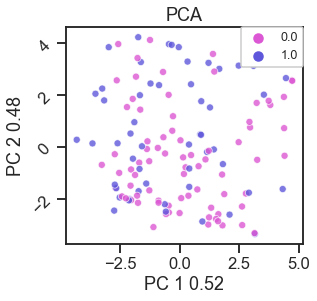

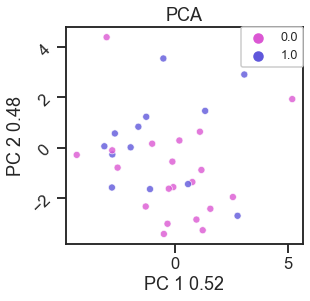

Results for AE: 

Best score for training data: 0.6384615384615383 

Best C: 0.08 



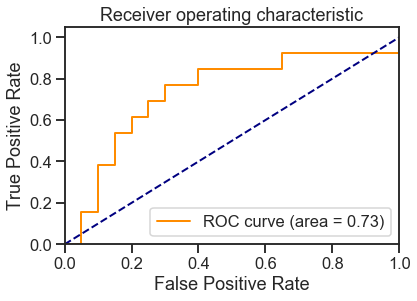

[[18  2]
 [ 8  5]]


              precision    recall  f1-score   support

           0       0.69      0.90      0.78        20
           1       0.71      0.38      0.50        13

    accuracy                           0.70        33
   macro avg       0.70      0.64      0.64        33
weighted avg       0.70      0.70      0.67        33

Training set score for Logistic Regression: 0.646154
Testing  set score for Logistic Regression: 0.696970
Best score for training data: 0.6076923076923076 

Best C: 1.0 

Best Gamma: 0.1 



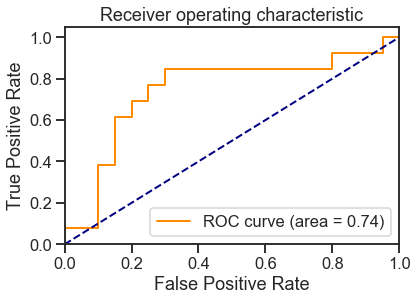

[[18  2]
 [10  3]]


              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.60      0.23      0.33        13

    accuracy                           0.64        33
   macro avg       0.62      0.57      0.54        33
weighted avg       0.63      0.64      0.59        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.636364
Best score for training data: 0.5769230769230769 

Best #estimators: 140 

Best max depth: None 



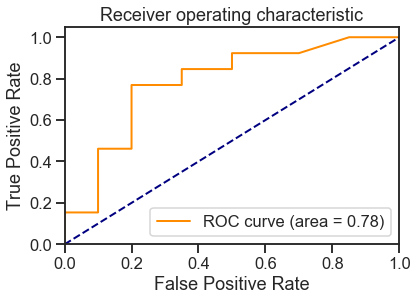

[[17  3]
 [ 7  6]]


              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.67      0.46      0.55        13

    accuracy                           0.70        33
   macro avg       0.69      0.66      0.66        33
weighted avg       0.69      0.70      0.68        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.696970
mutual information: 0.016365874208082224
AE 2 clusters -  silhoutte score: 0.3624168038368225
AE 3 clusters -  silhoutte score: 0.37113675475120544
AE 4 clusters -  silhoutte score: 0.40451574325561523
AE 5 clusters -  silhoutte score: 0.40184149146080017
AE 6 clusters -  silhoutte score: 0.39001521468162537


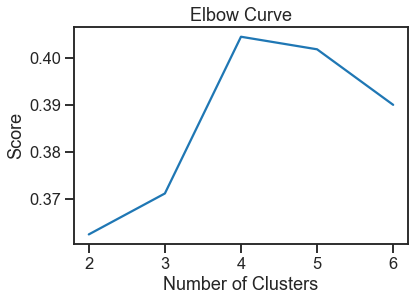

mutual information: 0.00348127218961062
AE 2 clusters -  silhoutte score: 0.34186094999313354
AE 3 clusters -  silhoutte score: 0.36932283639907837
AE 4 clusters -  silhoutte score: 0.3667260706424713
AE 5 clusters -  silhoutte score: 0.3975243866443634
AE 6 clusters -  silhoutte score: 0.39061683416366577


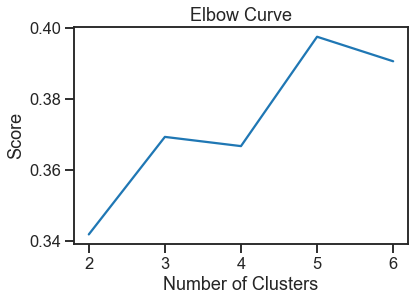

mutual information: 0.029361033048473404
AE 2 clusters -  silhoutte score: 0.3529950678348541
AE 3 clusters -  silhoutte score: 0.38449230790138245
AE 4 clusters -  silhoutte score: 0.36439213156700134
AE 5 clusters -  silhoutte score: 0.3738400936126709
AE 6 clusters -  silhoutte score: 0.3665962219238281


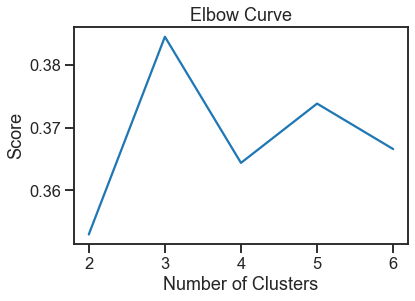

Compression: 70.58666666666667

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00136: early stopping


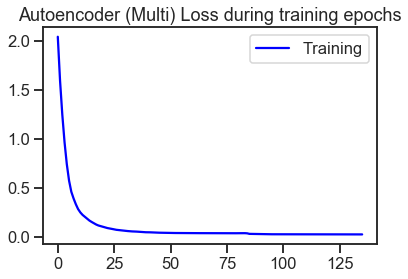

0.027329358687767615


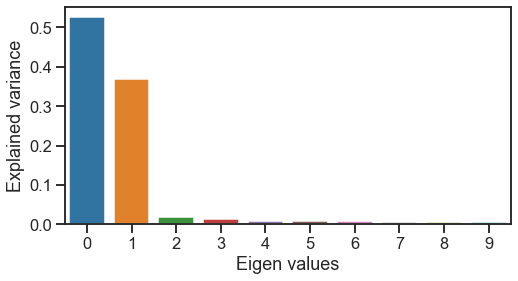

PCA on single-modal explained variance ratio: 0.9704107642173767


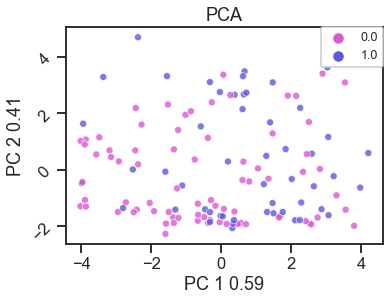

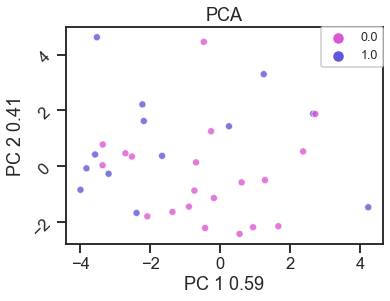

Results for AE: 

Best score for training data: 0.6615384615384615 

Best C: 0.08 



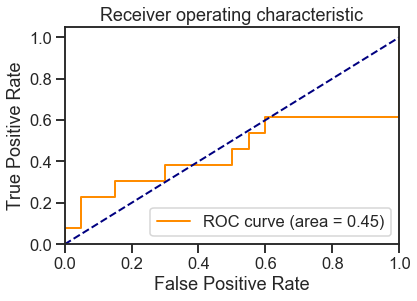

[[17  3]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.57      0.31      0.40        13

    accuracy                           0.64        33
   macro avg       0.61      0.58      0.57        33
weighted avg       0.62      0.64      0.61        33

Training set score for Logistic Regression: 0.669231
Testing  set score for Logistic Regression: 0.636364
Best score for training data: 0.6 

Best C: 1.0 

Best Gamma: 0.1 



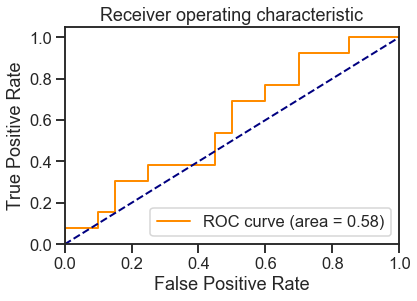

[[15  5]
 [ 8  5]]


              precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       0.50      0.38      0.43        13

    accuracy                           0.61        33
   macro avg       0.58      0.57      0.57        33
weighted avg       0.59      0.61      0.59        33

Training set score for SVM: 0.700000
Testing  set score for SVM: 0.606061
Best score for training data: 0.5846153846153845 

Best #estimators: 100 

Best max depth: 12 



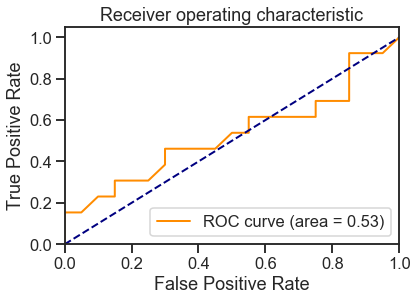

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061
mutual information: 0.07251285194669882
AE 2 clusters -  silhoutte score: 0.3282630443572998
AE 3 clusters -  silhoutte score: 0.37609216570854187
AE 4 clusters -  silhoutte score: 0.366877943277359
AE 5 clusters -  silhoutte score: 0.35668861865997314
AE 6 clusters -  silhoutte score: 0.3256906270980835


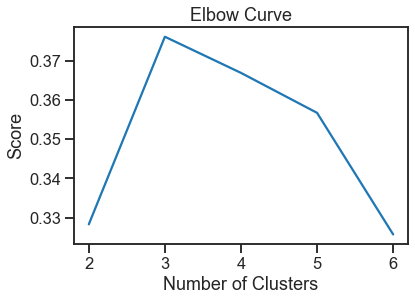

mutual information: 0.016518363182695485
AE 2 clusters -  silhoutte score: 0.30863308906555176
AE 3 clusters -  silhoutte score: 0.3537501394748688
AE 4 clusters -  silhoutte score: 0.3583834171295166
AE 5 clusters -  silhoutte score: 0.33734938502311707
AE 6 clusters -  silhoutte score: 0.3148951232433319


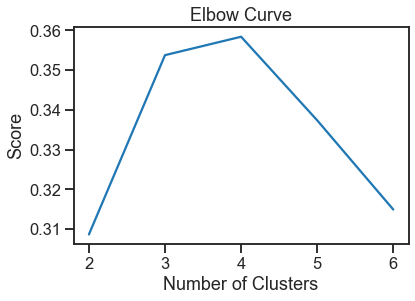

mutual information: 0.012293728046062215
AE 2 clusters -  silhoutte score: 0.2950340807437897
AE 3 clusters -  silhoutte score: 0.36701202392578125
AE 4 clusters -  silhoutte score: 0.3212302625179291
AE 5 clusters -  silhoutte score: 0.31038951873779297
AE 6 clusters -  silhoutte score: 0.3153707981109619


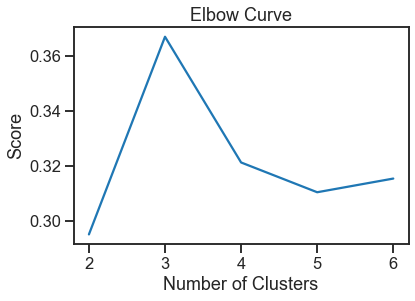

Compression: 70.58666666666667

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00108: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00134: early stopping


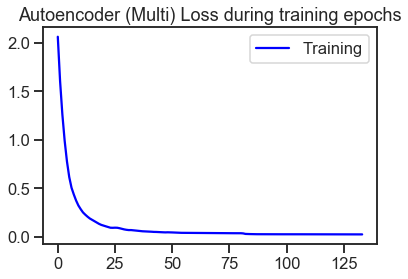

0.02709842762694909


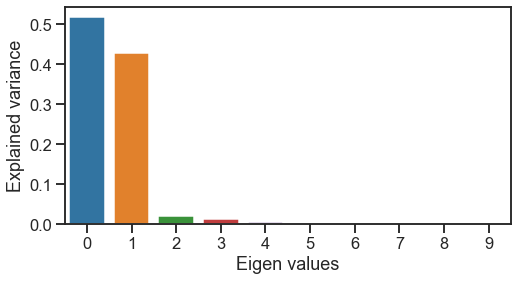

PCA on single-modal explained variance ratio: 0.9968243837356567


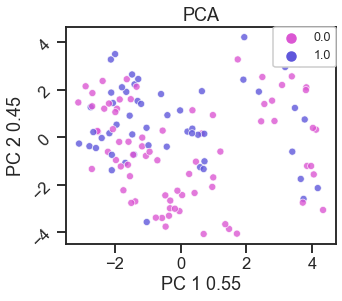

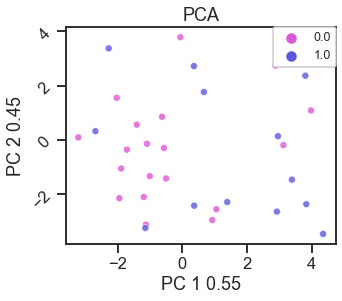

Results for AE: 

Best score for training data: 0.6076923076923076 

Best C: 0.08 



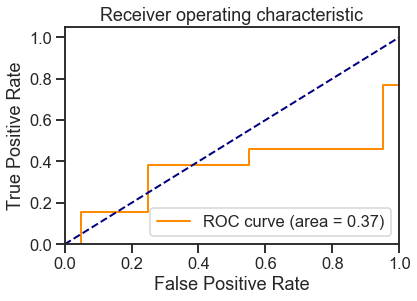

[[16  4]
 [11  2]]


              precision    recall  f1-score   support

           0       0.59      0.80      0.68        20
           1       0.33      0.15      0.21        13

    accuracy                           0.55        33
   macro avg       0.46      0.48      0.45        33
weighted avg       0.49      0.55      0.50        33

Training set score for Logistic Regression: 0.630769
Testing  set score for Logistic Regression: 0.545455
Best score for training data: 0.6 

Best C: 1.0 

Best Gamma: 0.1 



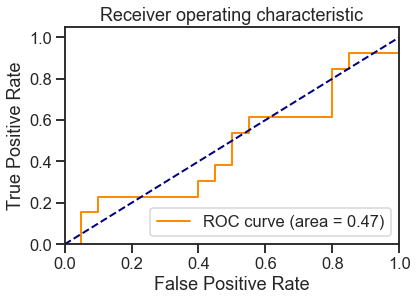

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.606061
Best score for training data: 0.5923076923076923 

Best #estimators: 100 

Best max depth: 12 



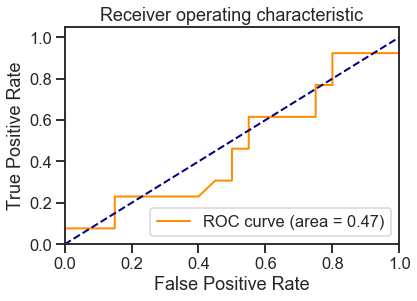

[[16  4]
 [10  3]]


              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.43      0.23      0.30        13

    accuracy                           0.58        33
   macro avg       0.52      0.52      0.50        33
weighted avg       0.54      0.58      0.54        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.575758
mutual information: 0.00021498047633589874
AE 2 clusters -  silhoutte score: 0.438113272190094
AE 3 clusters -  silhoutte score: 0.430275559425354
AE 4 clusters -  silhoutte score: 0.42406076192855835
AE 5 clusters -  silhoutte score: 0.3797319233417511
AE 6 clusters -  silhoutte score: 0.41074731945991516


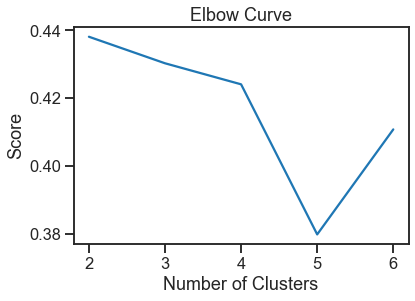

mutual information: 0.00045063599870930857
AE 2 clusters -  silhoutte score: 0.4468446969985962
AE 3 clusters -  silhoutte score: 0.4073157012462616
AE 4 clusters -  silhoutte score: 0.4229796230792999
AE 5 clusters -  silhoutte score: 0.39155158400535583
AE 6 clusters -  silhoutte score: 0.35845497250556946


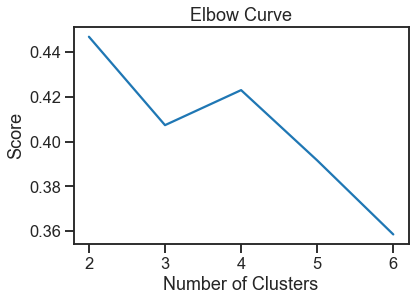

mutual information: 0.00045063599870930857
AE 2 clusters -  silhoutte score: 0.4468446969985962
AE 3 clusters -  silhoutte score: 0.3756793737411499
AE 4 clusters -  silhoutte score: 0.3893332779407501
AE 5 clusters -  silhoutte score: 0.3502918481826782
AE 6 clusters -  silhoutte score: 0.3758181035518646


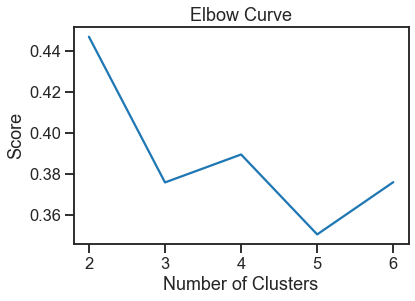

Compression: 70.58666666666667

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00129: early stopping


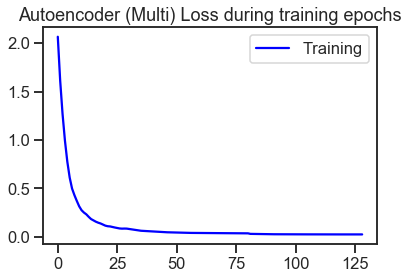

0.026378819174491443


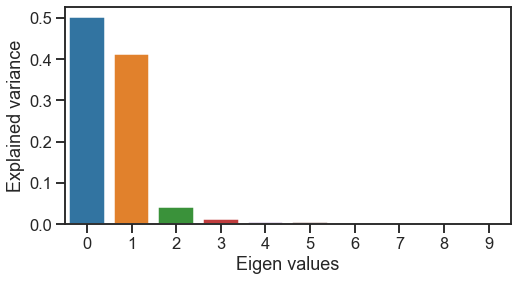

PCA on single-modal explained variance ratio: 0.9930593967437744


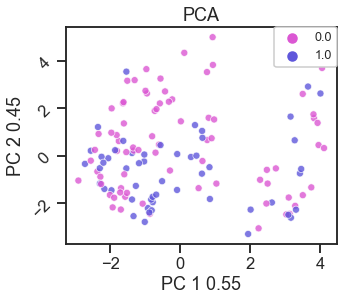

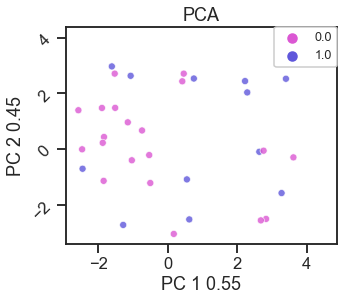

Results for AE: 

Best score for training data: 0.623076923076923 

Best C: 0.08 



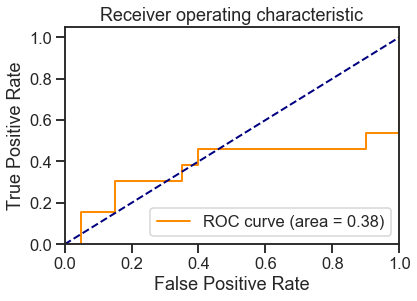

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for Logistic Regression: 0.638462
Testing  set score for Logistic Regression: 0.606061
Best score for training data: 0.6076923076923076 

Best C: 1.0 

Best Gamma: 0.1 



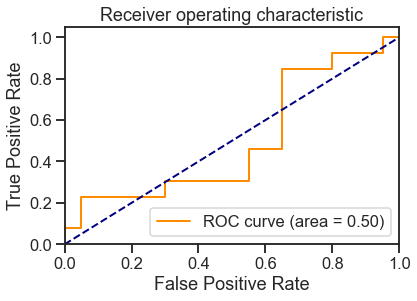

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for SVM: 0.653846
Testing  set score for SVM: 0.606061
Best score for training data: 0.6153846153846154 

Best #estimators: 140 

Best max depth: None 



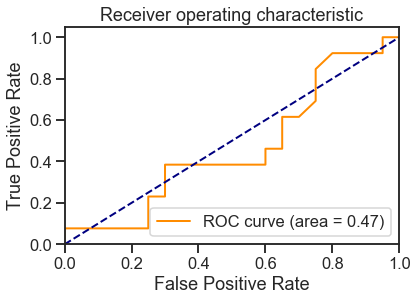

[[14  6]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.61      0.70      0.65        20
           1       0.40      0.31      0.35        13

    accuracy                           0.55        33
   macro avg       0.50      0.50      0.50        33
weighted avg       0.53      0.55      0.53        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.545455
mutual information: 0.00021498047633589874
AE 2 clusters -  silhoutte score: 0.4274686872959137
AE 3 clusters -  silhoutte score: 0.3922695517539978
AE 4 clusters -  silhoutte score: 0.4060620665550232
AE 5 clusters -  silhoutte score: 0.3540040850639343
AE 6 clusters -  silhoutte score: 0.37881264090538025


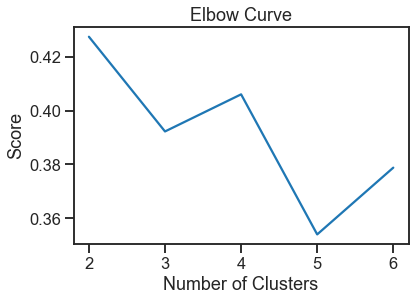

mutual information: 0.00045063599870930857
AE 2 clusters -  silhoutte score: 0.4348433017730713
AE 3 clusters -  silhoutte score: 0.3992711305618286
AE 4 clusters -  silhoutte score: 0.40253788232803345
AE 5 clusters -  silhoutte score: 0.3732626140117645
AE 6 clusters -  silhoutte score: 0.3349531888961792


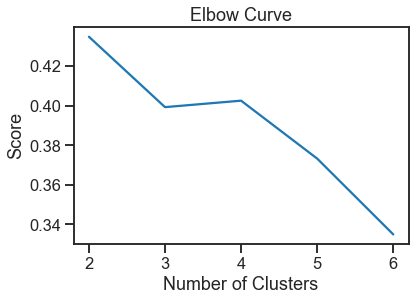

mutual information: 0.00045063599870930857
AE 2 clusters -  silhoutte score: 0.4348433017730713
AE 3 clusters -  silhoutte score: 0.3749164044857025
AE 4 clusters -  silhoutte score: 0.38098829984664917
AE 5 clusters -  silhoutte score: 0.3161885738372803
AE 6 clusters -  silhoutte score: 0.36600252985954285


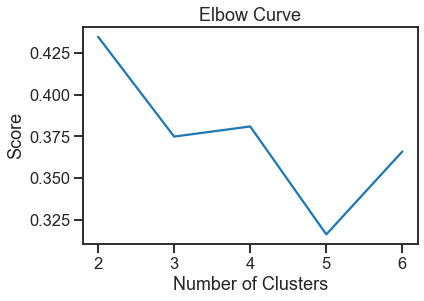

In [24]:
###  Hyperparameter tuning

encoding_dims=[150]
mus=[0,0.1,0.3,0.5,0.7,0.9,1]
dropouts = [0.25]
l1s = [0.00005]
l2s = [0.000003]
scores = []
for encoding_dim in encoding_dims:
    for mu in mus:
        for dropout in dropouts:
            for l1 in l1s:
                for l2 in l2s:
                    ## Build and Train Autoencoder
                    autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_train_first_norm,X_train_second_norm],
                                                                                  [X_train_first_norm,X_train_second_norm],
                                                                                  encoding_dim=encoding_dim, 
                                                                                  regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                                  dropout=dropout,
                                                                                  epochs=200,
                                                                                  mu=mu)
                    ## Encode datasets
                    X_latent_multi_ae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
                    X_latent_test_multi_ae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

                    ## PCA ON AUTOENCODER LATENT SPACE
                    X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_multi_ae, X_latent_test_multi_ae, y_train, y_test, n_components=10)

                    ### CLASSIFICATION ###
                    classify = Models.classify(X_latent_multi_ae, X_latent_test_multi_ae, np.ravel(y_train), np.ravel(y_test), model_type="AE")

                    ### CLUSTERING ###
                    clustering = Models.cluster(X_latent_multi_ae,np.ravel(y_train), model_type="AE")

                    scores.append([mu,dropout,l1,l2,loss] + classify + clustering)


In [17]:
scores = pd.DataFrame(scores,
                      columns=["mu","dropout","l1","l2","loss","LR accuracy","SVM accuracy", "RF accuracy", "LR_auc", "SVM_auc", "RF_auc","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,mu,dropout,l1,l2,loss,LR accuracy,SVM accuracy,RF accuracy,LR_auc,SVM_auc,RF_auc,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
0,0.5,0.25,0.00005,0.000003,0.033742,0.606061,0.606061,0.575758,0.403846,0.538462,0.509615,0.526998,0.058906,0.526376,0.044553,0.495458,0.093924
1,0.5,0.25,0.00005,0.000003,0.027201,0.575758,0.606061,0.636364,0.426923,0.561538,0.623077,0.391044,0.050024,0.406259,0.092205,0.381881,0.054995
2,0.5,0.25,0.00005,0.000003,0.026882,0.606061,0.606061,0.575758,0.515385,0.592308,0.563462,0.348498,0.000101,0.358102,0.000451,0.358102,0.000451
3,0.5,0.25,0.00005,0.000003,0.027052,0.515152,0.515152,0.484848,0.342308,0.442308,0.388462,0.370201,0.000009,0.427721,0.000445,0.422807,0.000778
4,0.5,0.25,0.00005,0.000003,0.027098,0.636364,0.606061,0.666667,0.726923,0.788462,0.780769,0.315157,0.018663,0.274524,0.031334,0.298595,0.032359
5,0.5,0.25,0.00005,0.000003,0.027231,0.636364,0.606061,0.515152,0.638462,0.596154,0.417308,0.433723,0.000256,0.247262,0.004125,0.398855,0.000737
6,0.5,0.25,0.00005,0.000003,0.027249,0.454545,0.606061,0.515152,0.311538,0.330769,0.453846,0.493448,0.039630,0.485858,0.012292,0.430482,0.031042
7,0.5,0.25,0.00005,0.000003,0.026964,0.575758,0.606061,0.575758,0.419231,0.484615,0.484615,0.333332,0.008726,0.382357,0.034458,0.335856,0.036798


In [22]:
scores.index = encoding_dims
data = scores[["LR accuracy","SVM accuracy","RF accuracy"]] 

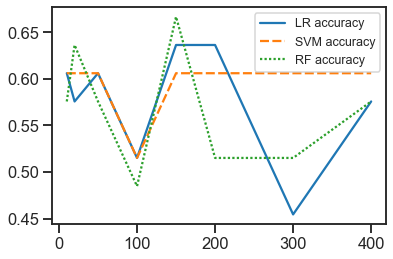

In [23]:
ax = sns.lineplot(data=data[["LR accuracy","SVM accuracy","RF accuracy"]])
plt.legend(fontsize='x-small')

### Results

| dim | mu  | l1      | l2      | Dropout | Loss   | Accuracy (LR) | Accuracy (SVM) | Accuracy (RF) | ROC-AUC (LR) | ROC-AUC (SVM) | ROC-AUC (RF) | SS (K-means) | MI (K-means) | SS (Spectral) | MI (Spectral) | SS (Hierarch.) | MI (Hierarch.) |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.5 | 0       | 0       | 0.00    | 0.0159 |  0.57         | 0.63           | 0.57          | 0.5153       | 0.5346        | 0.5403       | 0.10         | 0.0764       | 0.11          | 0.0326        | 0.09           | 0.0454         |
| 50  | 0.5 | 0       | 0       | 0.05    | 0.0189 |  0.60         | 0.66           | 0.51          | 0.4961       | 0.5961        | 0.4942       | 0.14         | 0.0003       | 0.14          | 0.0010        | 0.12           | 0.0027         |
| 50  | 0.5 | 0       | 0       | 0.10    | 0.0220 |  0.57         | 0.57           | 0.45          | 0.4961       | 0.4923        | 0.4923       | 0.19         | 0.0221       | 0.19          | 0.0178        | 0.19           | 0.0122         |
| 50  | 0.5 | 0       | 0       | 0.15    | 0.0227 |  0.63         | 0.57           | 0.57          | 0.5269       | 0.5692        | 0.4750       | 0.19         | 0.0009       | 0.20          | 0.0000        | 0.17           | 0.0081         |
| 50  | 0.5 | 0       | 0       | 0.25    | 0.0240 |  0.66         | 0.60           | 0.57          | 0.4846       | 0.5615        | 0.6750       | 0.20         | 0.0000       | 0.20          | 0.0002        | 0.17           | 0.0012         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.5 | 0.00005 | 0       | 0.25    | 0.0270 |  0.63         | 0.60           | 0.54          | 0.4769       | 0.5384        | 0.5269       | 0.29         | 0.0000       | 0.29          | 0.0002        | 0.26           | 0.0087         |
| 50  | 0.5 | 0.0002  | 0       | 0.25    | 0.0276 |  0.60         | 0.60           | 0.63          | 0.5269       | 0.4000        | 0.6461       | 0.40         | 0.0144       | 0.40          | 0.0144        | 0.38           | 0.0109         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.5 | 0.00005 | 0.000003| 0.25    | 0.0268 |  0.63         | 0.60           | 0.66          | 0.7153       | 0.7192        | 0.6750       | 0.39         | 0.0029       | 0.38          | 0.0018        | 0.36           | 0.0000         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 150 | 0.5 | 0.00005 | 0.000003| 0.25    | 0.0270 |  0.63         | 0.60           | 0.66          | 0.7269       | 0.7884        | 0.7807       | 0.31         | 0.0186       | 0.27          | 0.0313        | 0.29           | 0.0323         |


Compression: 105.88

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00099: early stopping


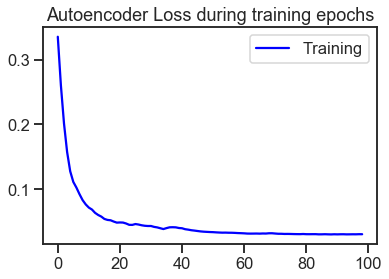

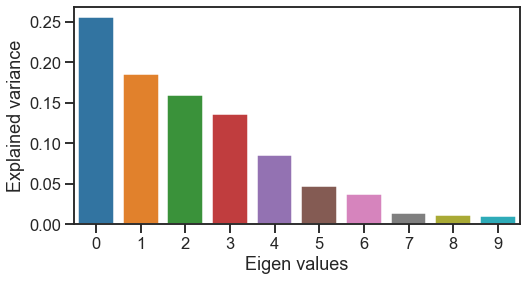

PCA on single-modal explained variance ratio: 0.9434438943862915


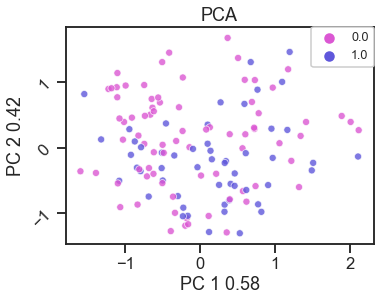

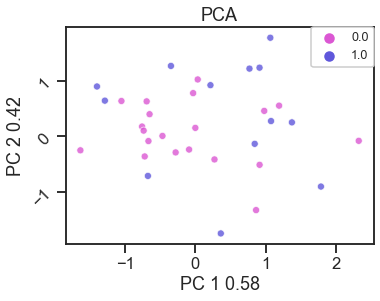

Results for AE: 

Best score for training data: 0.6384615384615383 

Best C: 0.08 



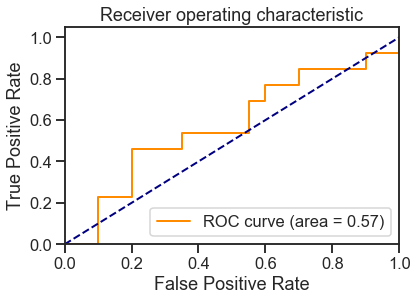

[[18  2]
 [10  3]]


              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.60      0.23      0.33        13

    accuracy                           0.64        33
   macro avg       0.62      0.57      0.54        33
weighted avg       0.63      0.64      0.59        33

Training set score for Logistic Regression: 0.692308
Testing  set score for Logistic Regression: 0.636364
Best score for training data: 0.6153846153846153 

Best C: 1.0 

Best Gamma: 0.1 



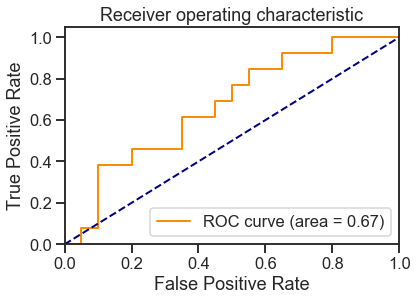

[[18  2]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       0.67      0.31      0.42        13

    accuracy                           0.67        33
   macro avg       0.67      0.60      0.59        33
weighted avg       0.67      0.67      0.63        33

Training set score for SVM: 0.707692
Testing  set score for SVM: 0.666667
Best score for training data: 0.6076923076923078 

Best #estimators: 140 

Best max depth: None 



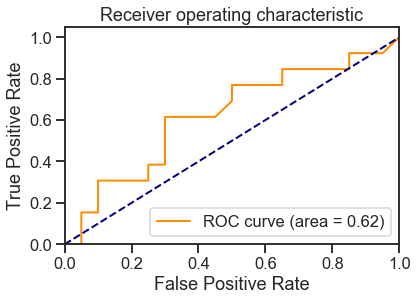

[[16  4]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.64      0.80      0.71        20
           1       0.50      0.31      0.38        13

    accuracy                           0.61        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.58      0.61      0.58        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061
mutual information: 0.03640088203412082
AE 2 clusters -  silhoutte score: 0.16861486434936523
AE 3 clusters -  silhoutte score: 0.17695584893226624
AE 4 clusters -  silhoutte score: 0.18356095254421234
AE 5 clusters -  silhoutte score: 0.19816945493221283
AE 6 clusters -  silhoutte score: 0.2135956585407257


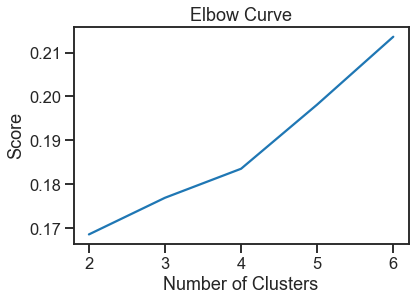

mutual information: 0.0008743513391288293
AE 2 clusters -  silhoutte score: 0.22366087138652802
AE 3 clusters -  silhoutte score: 0.18038570880889893
AE 4 clusters -  silhoutte score: 0.16400906443595886
AE 5 clusters -  silhoutte score: 0.1729075163602829
AE 6 clusters -  silhoutte score: 0.1864602267742157


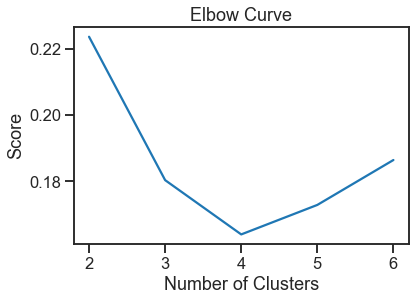

mutual information: 0.000668785402026461
AE 2 clusters -  silhoutte score: 0.20892095565795898
AE 3 clusters -  silhoutte score: 0.16451722383499146
AE 4 clusters -  silhoutte score: 0.15569724142551422
AE 5 clusters -  silhoutte score: 0.16698338091373444
AE 6 clusters -  silhoutte score: 0.18048936128616333


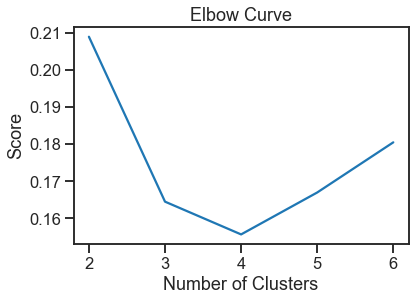

Compression: 105.88

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00035: early stopping


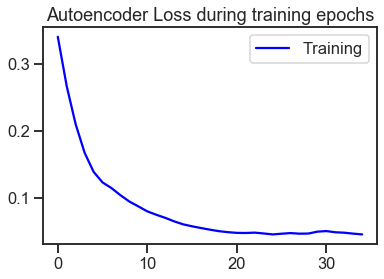

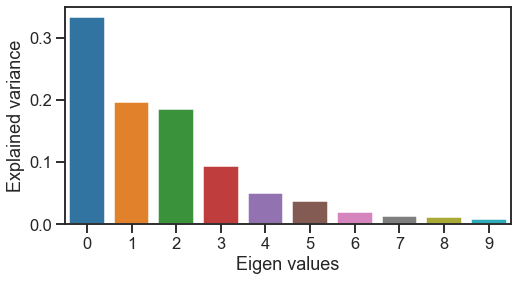

PCA on single-modal explained variance ratio: 0.9503766894340515


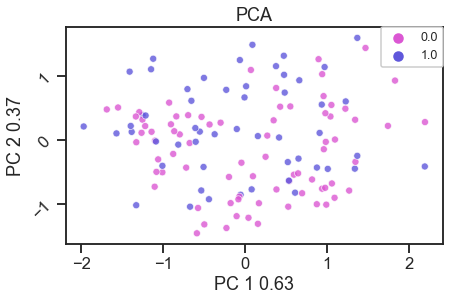

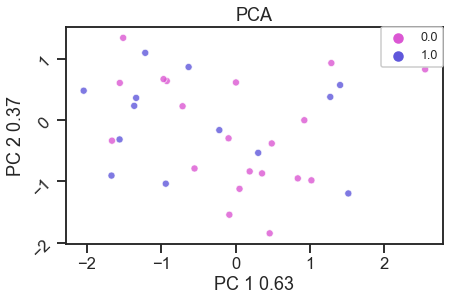

Results for AE: 

Best score for training data: 0.6769230769230768 

Best C: 0.08 



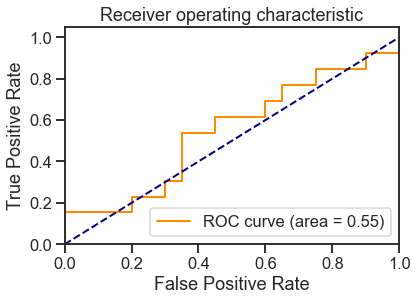

[[14  6]
 [10  3]]


              precision    recall  f1-score   support

           0       0.58      0.70      0.64        20
           1       0.33      0.23      0.27        13

    accuracy                           0.52        33
   macro avg       0.46      0.47      0.45        33
weighted avg       0.48      0.52      0.49        33

Training set score for Logistic Regression: 0.692308
Testing  set score for Logistic Regression: 0.515152
Best score for training data: 0.6615384615384615 

Best C: 1.0 

Best Gamma: 0.1 



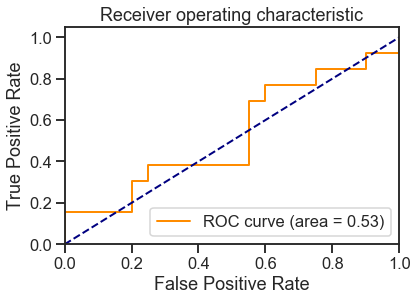

[[16  4]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.64      0.80      0.71        20
           1       0.50      0.31      0.38        13

    accuracy                           0.61        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.58      0.61      0.58        33

Training set score for SVM: 0.700000
Testing  set score for SVM: 0.606061
Best score for training data: 0.6307692307692307 

Best #estimators: 100 

Best max depth: 12 



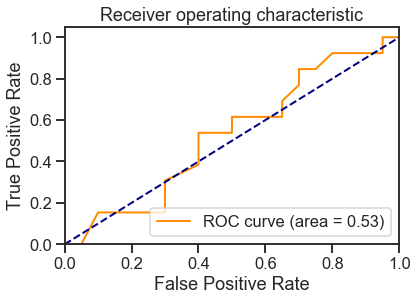

[[14  6]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.61      0.70      0.65        20
           1       0.40      0.31      0.35        13

    accuracy                           0.55        33
   macro avg       0.50      0.50      0.50        33
weighted avg       0.53      0.55      0.53        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.545455
mutual information: 5.5064695756933674e-05
AE 2 clusters -  silhoutte score: 0.22526131570339203
AE 3 clusters -  silhoutte score: 0.2145080268383026
AE 4 clusters -  silhoutte score: 0.22810588777065277
AE 5 clusters -  silhoutte score: 0.2140297144651413
AE 6 clusters -  silhoutte score: 0.2055792659521103


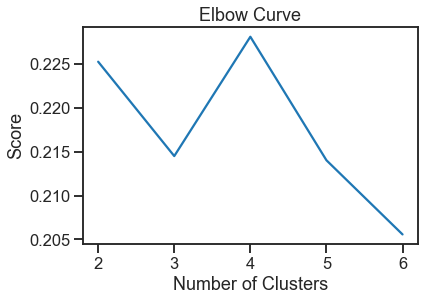

mutual information: 0.000526849824188075
AE 2 clusters -  silhoutte score: 0.21222643554210663
AE 3 clusters -  silhoutte score: 0.2075367569923401
AE 4 clusters -  silhoutte score: 0.21784764528274536
AE 5 clusters -  silhoutte score: 0.2004804164171219
AE 6 clusters -  silhoutte score: 0.21034693717956543


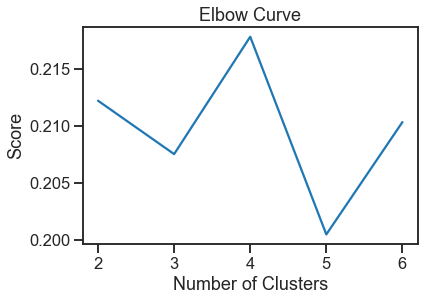

mutual information: 0.005111811655926306
AE 2 clusters -  silhoutte score: 0.2191045582294464
AE 3 clusters -  silhoutte score: 0.1996162384748459
AE 4 clusters -  silhoutte score: 0.19407248497009277
AE 5 clusters -  silhoutte score: 0.18504013121128082
AE 6 clusters -  silhoutte score: 0.19445577263832092


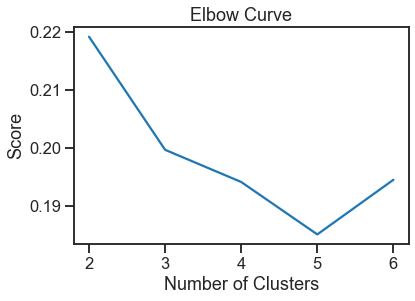

Compression: 105.88

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00070: early stopping


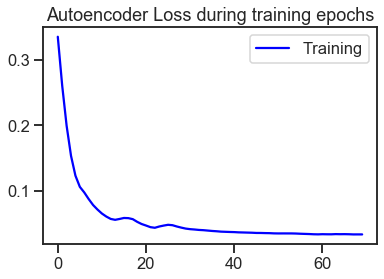

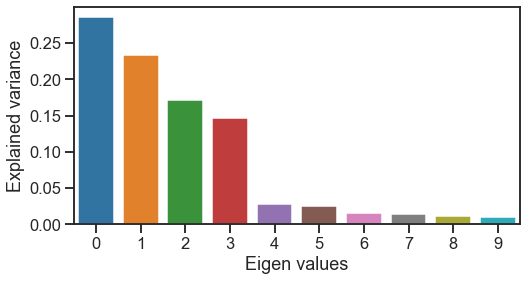

PCA on single-modal explained variance ratio: 0.9412816762924194


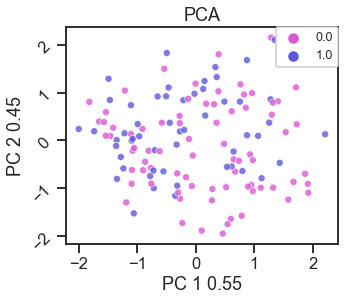

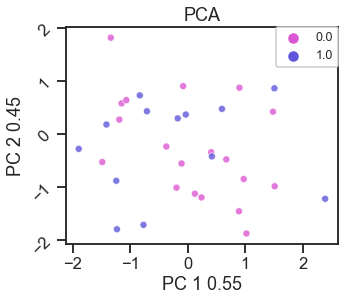

Results for AE: 

Best score for training data: 0.6153846153846153 

Best C: 0.08 



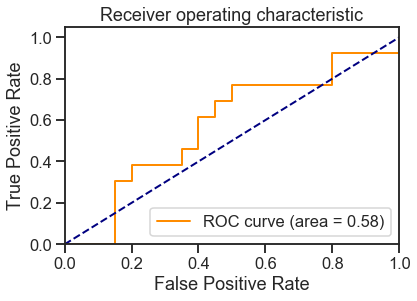

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for Logistic Regression: 0.638462
Testing  set score for Logistic Regression: 0.606061
Best score for training data: 0.5923076923076923 

Best C: 0.1 

Best Gamma: scale 



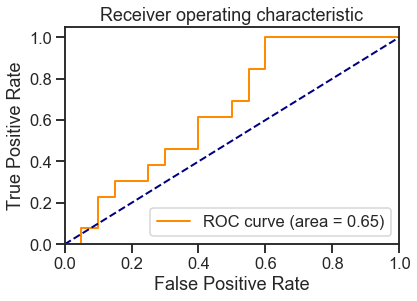

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33

Training set score for SVM: 0.592308
Testing  set score for SVM: 0.606061


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score for training data: 0.6 

Best #estimators: 140 

Best max depth: None 



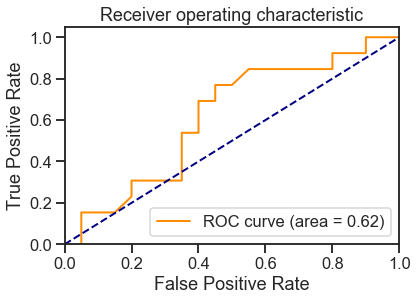

[[18  2]
 [11  2]]


              precision    recall  f1-score   support

           0       0.62      0.90      0.73        20
           1       0.50      0.15      0.24        13

    accuracy                           0.61        33
   macro avg       0.56      0.53      0.48        33
weighted avg       0.57      0.61      0.54        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061
mutual information: 0.021726669365613148
AE 2 clusters -  silhoutte score: 0.19919610023498535
AE 3 clusters -  silhoutte score: 0.2076071947813034
AE 4 clusters -  silhoutte score: 0.2110196352005005
AE 5 clusters -  silhoutte score: 0.20281586050987244
AE 6 clusters -  silhoutte score: 0.2135675996541977


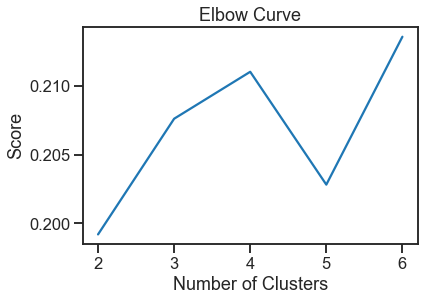

mutual information: 0.0024726635852203344
AE 2 clusters -  silhoutte score: 0.1891232132911682
AE 3 clusters -  silhoutte score: 0.19977445900440216
AE 4 clusters -  silhoutte score: 0.18769598007202148
AE 5 clusters -  silhoutte score: 0.1822313815355301
AE 6 clusters -  silhoutte score: 0.19865728914737701


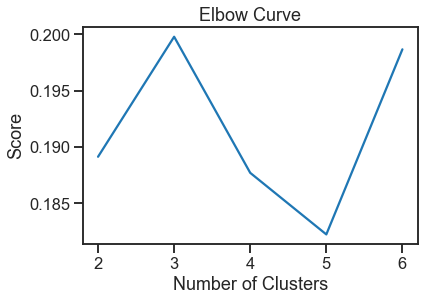

mutual information: 0.0009345880578005224
AE 2 clusters -  silhoutte score: 0.17823882400989532
AE 3 clusters -  silhoutte score: 0.19593843817710876
AE 4 clusters -  silhoutte score: 0.17954638600349426
AE 5 clusters -  silhoutte score: 0.1728825718164444
AE 6 clusters -  silhoutte score: 0.19259074330329895


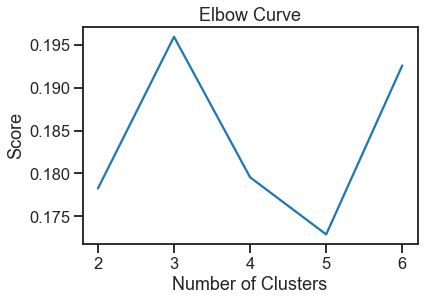

Compression: 105.88

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00114: early stopping


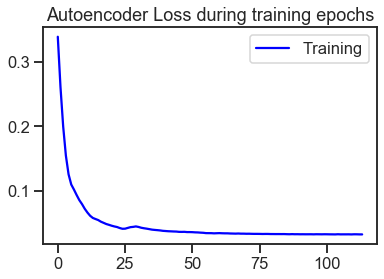

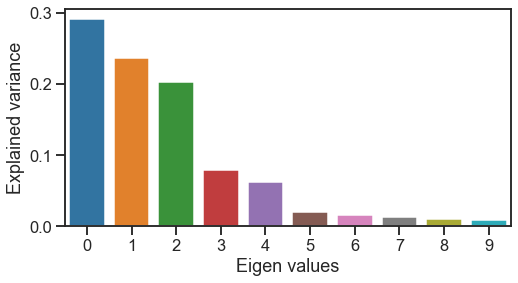

PCA on single-modal explained variance ratio: 0.9398872256278992


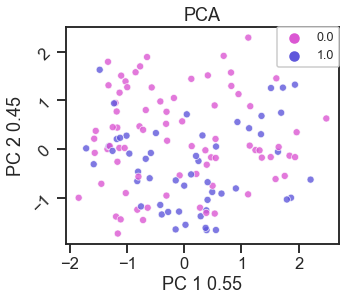

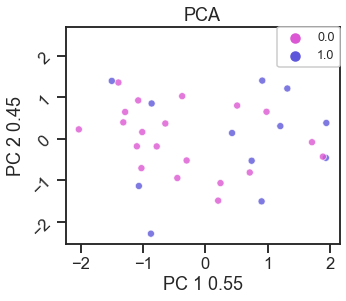

Results for AE: 

Best score for training data: 0.6461538461538461 

Best C: 0.08 



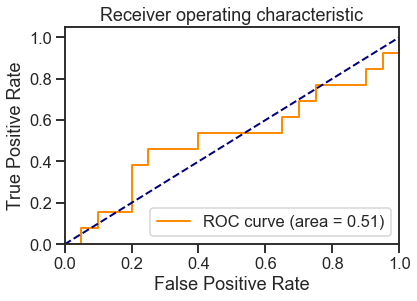

[[17  3]
 [11  2]]


              precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.40      0.15      0.22        13

    accuracy                           0.58        33
   macro avg       0.50      0.50      0.47        33
weighted avg       0.53      0.58      0.52        33

Training set score for Logistic Regression: 0.707692
Testing  set score for Logistic Regression: 0.575758
Best score for training data: 0.6307692307692306 

Best C: 1.0 

Best Gamma: 0.1 



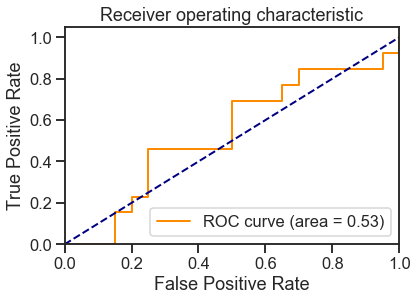

[[16  4]
 [11  2]]


              precision    recall  f1-score   support

           0       0.59      0.80      0.68        20
           1       0.33      0.15      0.21        13

    accuracy                           0.55        33
   macro avg       0.46      0.48      0.45        33
weighted avg       0.49      0.55      0.50        33

Training set score for SVM: 0.746154
Testing  set score for SVM: 0.545455
Best score for training data: 0.6230769230769231 

Best #estimators: 100 

Best max depth: 12 



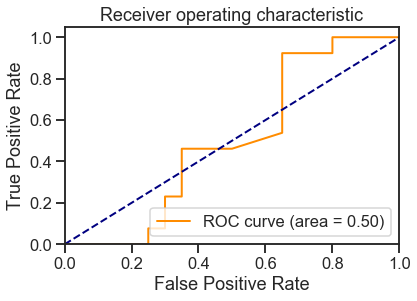

[[14  6]
 [12  1]]


              precision    recall  f1-score   support

           0       0.54      0.70      0.61        20
           1       0.14      0.08      0.10        13

    accuracy                           0.45        33
   macro avg       0.34      0.39      0.35        33
weighted avg       0.38      0.45      0.41        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.454545
mutual information: 0.000209194501840825
AE 2 clusters -  silhoutte score: 0.1969800740480423
AE 3 clusters -  silhoutte score: 0.2072877436876297
AE 4 clusters -  silhoutte score: 0.2269252985715866
AE 5 clusters -  silhoutte score: 0.20932520925998688
AE 6 clusters -  silhoutte score: 0.19602979719638824


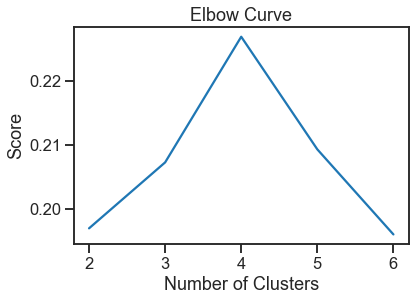

mutual information: 6.052810403441833e-05
AE 2 clusters -  silhoutte score: 0.22212862968444824
AE 3 clusters -  silhoutte score: 0.21611125767230988
AE 4 clusters -  silhoutte score: 0.21691593527793884
AE 5 clusters -  silhoutte score: 0.19927045702934265
AE 6 clusters -  silhoutte score: 0.19357018172740936


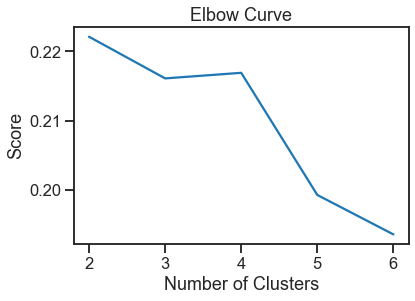

mutual information: 0.002832240480541993
AE 2 clusters -  silhoutte score: 0.19699126482009888
AE 3 clusters -  silhoutte score: 0.16120290756225586
AE 4 clusters -  silhoutte score: 0.17030389606952667
AE 5 clusters -  silhoutte score: 0.1683458536863327
AE 6 clusters -  silhoutte score: 0.17185743153095245


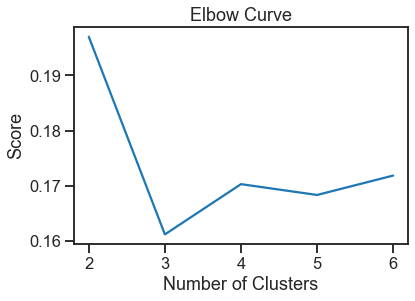

In [124]:
dropouts = [0.2,0.25]
l1s = [0.000005]
l2s = [0.000005,0.00001]
scores = []
for dropout in dropouts:
    for l1 in l1s:
        for l2 in l2s:
            ## Build and Train Autoencoder
            autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_concat,
                                                                          X_train_concat,
                                                                          encoding_dim=100, 
                                                                          regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                          dropout=dropout,
                                                                          epochs=200)
            ## Encode datasets
            X_latent_ae = Models.encode_dataset(X_train_concat, encoder)
            X_latent_test_ae = Models.encode_dataset(X_test_concat, encoder)
         
            ## PCA ON AUTOENCODER LATENT SPACE
            X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_ae, X_latent_test_ae, y_train, y_test, n_components=10)

            ### CLASSIFICATION ###
            classify = Models.classify(X_latent_ae, X_latent_test_ae, np.ravel(y_train), np.ravel(y_test), model_type="AE")

            ### CLUSTERING ###
            clustering = Models.cluster(X_latent_ae,np.ravel(y_train_map), model_type="AE")

            scores.append([mu,dropout,l1,l2,loss] + classify + clustering)


In [7]:
scores = pd.DataFrame(scores,
                      columns=["mu","dropout","l1","l2","loss","LR_accuracy","SVM_accuracy", "RF_accuracy", "LR_auc", "SVM_auc", "RF_auc","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,mu,dropout,l1,l2,loss,LR_accuracy,SVM_accuracy,RF_accuracy,LR_auc,SVM_auc,RF_auc,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
0,0.5,0.25,0.000000,0,0.022848,0.575758,0.575758,0.606061,0.473077,0.496154,0.476923,0.208409,0.000013,0.207419,0.000448,0.194171,0.000061
1,0.5,0.25,0.000001,0,0.030904,0.575758,0.575758,0.575758,0.546154,0.496154,0.594231,0.228330,0.036401,0.226257,0.014883,0.207957,0.033440
2,0.5,0.25,0.000005,0,0.036155,0.606061,0.606061,0.606061,0.507692,0.534615,0.548077,0.253864,0.000132,0.254855,0.000769,0.223008,0.003138
3,0.5,0.25,0.000010,0,0.032941,0.636364,0.606061,0.606061,0.469231,0.476923,0.494231,0.227300,0.000590,0.242299,0.001734,0.209217,0.002607
4,0.5,0.25,0.000050,0,0.026921,0.606061,0.606061,0.393939,0.307692,0.376923,0.378846,0.427283,0.016744,0.423750,0.009981,0.417373,0.014346
5,0.5,0.25,0.000100,0,0.027738,0.606061,0.606061,0.636364,0.576923,0.642308,0.600000,0.310373,0.020668,0.314558,0.018793,0.295007,0.004051
